# 개요

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Policy를 갱신하는 기법 (정책 계산 방법)
  - 정책 반복법
    - 행동을 중시
    - 행동을 기반으로 정책을 갱신 -> 행동을 유도
    - **정책 경사법**

  - 가치 반복법
    - 가치를 중시
    - 가치 계산이 핵심 -> 가치를 많이 주는 방향으로 정책이 갱신
    - **Sarsa, Q-Learning, DQN,..**

# 미로게임

- 보드게임 
- 게임판 : 3 x 3, 정사각형 
- 특징
  - 입구와 출구가 각각 1개만 존재
  - 막힌 사각형의 격자형 칸에 이동할수 있는 방향이 존재
  - 에이전트(마우스) 4방향으로 이동 가능
  - 액션 : 상(0), 우(1), 하(2), 좌(3)
  - 상태 : 미로게임 격자칸의 위치 정보 (0~8)
  - 정책 ? (본 노트의 목적)
  - 게임뷰는 탑뷰
  - 1 step에 한칸씩 이동
- 목적
  - **에이전트는 미로게임판에서 최단거리로 입구에서 출발하여 출구로 나간다**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 게임 보드판

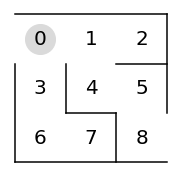

In [ ]:
# 게임의 전체 크기
fig = plt.figure( figsize=(3,3) )

# 외곽 벽 그리기
# 수평선 2개
plt.plot( [0, 3],[ 3, 3], color='k') # 맨위 수평선
plt.plot( [0, 3],[ 0, 0], color='k') # 맨아래 수평선
plt.plot( [0, 0],[ 0, 2], color='k') # 왼쪽 수직선 -> 입구표시
plt.plot( [3, 3],[ 1, 3], color='k') # 오른족 수직선

# 내부 미로
plt.plot( [1, 1],[1 , 2], color='k')
plt.plot( [2, 3],[2 , 2], color='k')
plt.plot( [1, 2],[1 , 1], color='k')
plt.plot( [2, 2],[0 , 1], color='k')

# 각 포인트 위치 정보 표시 -> 상태
# 0,1,2 ~ 8까지 위치 정보 표시
'''
0 1 2
3 4 5
6 7 8
'''
for x in range(3):
  for y in range(3):
    plt.text( x + 0.5, 3 - y - 0.5, str(x+3*y), size=20, ha='center', va='center' )

# 에이전트 표시 -> 시작위치 0번(0,0)에 위치
mouse = plt.plot( 0 + 0.5, 3 - 0 - 0.5, marker='o', markersize=30, color='#dadada' )


# 눈금정리
plt.tick_params(bottom=False, left=False,          # - 표시 제거
                labelbottom=False, labelleft=False # 수치값 제거
                )

# 차트 박스 제거
plt.box( False )

# 출력
plt.show()

# 요소 설계

|강화 학습 요소|미로 게임|
|--:|:--|
|에이전트|마우스|
|환경|미로 게임(유한게임)|
|목적|0번 위치에서(입구) 8번 위치까지(골인/출구) 최단거리 이동|
|행동|4방향 존재, 상우하좌(0123)|
|에피소드|0번에서 출발해서 8번에 도착하면 게임 종료|
|상태|에이전트의 위치(0~8)|
|보상|골인 지점까지 이동하는 행동을 중시하겠다.->정책경사법으로 처리|
|정책갱신(학습방법)|정책 경사법|
|파라미터변경주기(정책갱신시퀀스)|- 정책 결정에 영향을 미치는 가중치 담당<br>- 정책은 행동에 영향을 미친다<br>- 각 미로상의 포인트(상태)에서는 갈수 있는곳과 갈수 없는 곳에 대한 정보를 가지고 있다<br>- 1 에피소드가 종료되면 파라미터를 일괄 갱신하겠다(수식참고)|

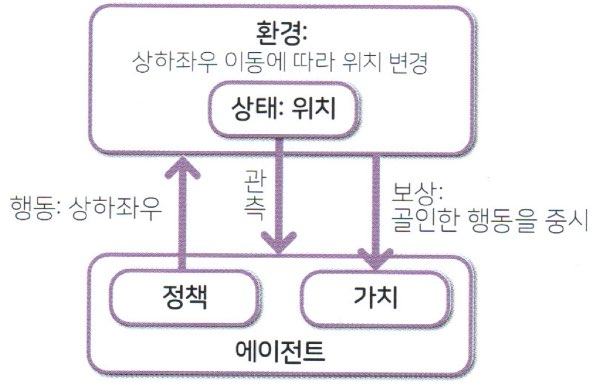

In [47]:
from IPython.display import Image
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/미로게임_학습사이클.jpg')

# 정책 계산법에서는 보상없이 행동의 로그를 이용하여 정책을 갱신한다
# 가치 계산법에서는 각 상태의 가치를 게산해서 정책을 갱신하고 행동한다

# 정책(Policy)

- 에이전트의 상태 정의
  - 미로상에서 에이전트가 취할수 있는 행동 확률
  - 특정 상태에서 특정 행동을 취할 확률
  - 최초에는 모든 방향에 대해서 동등한 확률을 가진다.
  - 이것을 기준으로 정책을 묘사할수 있다

- 특정 상태(미로상의 특정 포인트)에서 에이전트가 취할수 있는 행동 (갈수있다1, 없다 nan)

|구분|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|np.nan|1|1|np.nan|
|p1|:--:|:--:|:--:|:--:|
|p2|:--:|:--:|:--:|:--:|
|p3|:--:|:--:|:--:|:--:|
|p4|:--:|:--:|:--:|:--:|
|p5|:--:|:--:|:--:|:--:|
|p6|:--:|:--:|:--:|:--:|
|p7|:--:|:--:|:--:|:--:|
|p8|:--:|:--:|:--:|:--:|

- 기초 정책을 확률로 표현하면 (softmax)

|구분|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|0|0.5|0.5|0|
|p1|:--:|:--:|:--:|:--:|
|p2|:--:|:--:|:--:|:--:|
|p3|:--:|:--:|:--:|:--:|
|p4|:--:|:--:|:--:|:--:|
|p5|:--:|:--:|:--:|:--:|
|p6|:--:|:--:|:--:|:--:|
|p7|:--:|:--:|:--:|:--:|
|p8|:--:|:--:|:--:|:--:|

## 파라마터 초기값 표현

- 배열, 2차원

In [ ]:
# (갈수있다1, 없다 nan)
theta_zero = np.array( [
  # 상, 우, 하, 좌
  [ np.nan, 1, 1, np.nan], #0
  [ np.nan, 1, 1, 1], #1
  [ np.nan, np.nan, np.nan, 1], #2
  [ 1, np.nan, 1, np.nan], #3
  [ 1, 1, np.nan, np.nan], #4
  [ np.nan, np.nan, 1, 1], #5
  [ 1, 1, np.nan, np.nan], #6
  [ np.nan, np.nan, np.nan, 1], #7
] )

theta_zero

array([[nan,  1.,  1., nan],
       [nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.],
       [ 1., nan,  1., nan],
       [ 1.,  1., nan, nan],
       [nan, nan,  1.,  1.],
       [ 1.,  1., nan, nan],
       [nan, nan, nan,  1.]])

In [ ]:
# np.nansum()을 사용하면 nan을 배제하고 합산한다
theta_zero[0], np.sum(theta_zero[0]), np.nansum(theta_zero[0])

(array([nan,  1.,  1., nan]), nan, 2.0)

In [ ]:
theta_zero[0] / np.nansum(theta_zero[0])

array([nan, 0.5, 0.5, nan])

In [ ]:
output = np.zeros_like( theta_zero )
output

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# 직접 구현하는 활성화 함수 -> 확률로 계산해서 표현한다
def mySoftmax( theta ):
  # 결과를 담는 그릇
  output = np.zeros_like( theta )

  # 데이터가 큰수가 존재하고, 복잡한 범위를 가진 요소로 구성되어 있다면
  # 지수함수로 일괄처리해서 진행
  theta = np.exp( theta )

  for i in range( theta.shape[0] ):
    # 한줄씩 평균을 계산해서 대체
    output[i] = theta[i] / np.nansum(theta[i])
  
  # nan -> 0 처리
  return np.nan_to_num(output)

mySoftmax( theta_zero )

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.5       , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

# 게임 진행및 정책 계산시 필요한 기능

In [ ]:
# 정책에 따른, 상태를 고려하여, 행동 정보 추출
def getAction( policy, state ):
  '''
    policy : 2차원 배열, 정책
    state  : 미로 게임상의 위치정보
    특정 위치의 특정 정책은 policy[state]
  '''
  # 특정 위치에서(상태), 특정 정책을 고려하여 행동을 결정
  # 확률을 기반으로 행동을 결정
  # 행동 0, 1, 2, 3
  return np.random.choice([0,1,2,3], p=policy[state])

In [ ]:
# 행동에 따른 다음 상태값 정보(포지션) 획득
def getNextState( curState, nextAction ):
  '''
    curState   : 현재 상태
    nextAction : 다음 행동
  '''
  if   nextAction == 0: # 위로 이동
    return curState - 3
  elif nextAction == 1: # 오른쪽 이동
    return curState + 1
  elif nextAction == 2: # 밑으로 이동
    return curState + 3
  elif nextAction == 3: # 왼쪽 이동
    return curState - 1

# 정책 계산(갱신) 없이 기본 시뮬레이션 진행

In [ ]:
# 게임이 시작하면 에이전트의 초기 위치
AGENT_FIRST_STATE = 0
# 에이전트 위치가 AGENT_LAST_STATE 와 같다면 게임 종료
AGENT_LAST_STATE  = 8
# 최초 정책(확률)
theta             = mySoftmax( theta_zero )

In [ ]:
# 1 에피소드 진행
def simulation_game( updatedPolicy ):
  # 로그 -> 데이터 (2-D 배열)
  # [ [ 상태, 다음행동 ], ... ]
  # 1. 최초 로그
  act_his      = [ [ AGENT_FIRST_STATE, np.nan ] ]
  # 에이전트의 초기 위치
  에이전트위치 = AGENT_FIRST_STATE
  while True:
    # 2. 액션 획득(다음 행동값)
    agent_action = getAction( updatedPolicy, 에이전트위치 )

    # 3. 마지막 로그의 다음 행동값에 따른 위치 정보(상태) 획득
    next_agent_state = getNextState( 에이전트위치, agent_action )

    # 4. 현재 마지막 로그에 다음 행동을 업데이트
    '''
      0번 위치에서 우측으로 이동했다면
      [ [ AGENT_FIRST_STATE, np.nan ] ] => [ [ AGENT_FIRST_STATE, 1 ] ]
    '''
    act_his[-1][-1] = agent_action

    # 5. 다음 상태에서 로그 추가 (다음행동은 nan)
    act_his.append( [ next_agent_state, np.nan ] )

    # 6. 현재 에이전트의 위치를 변경
    에이전트위치 = next_agent_state

    # 7. 에이전트 위치가 AGENT_LAST_STATE 라면 게임 종료
    if 에이전트위치 == AGENT_LAST_STATE:
      break

  return act_his

In [ ]:
# 한번의 에피소드 진행
# act_his : 에이전트가 0 ~> 8까지 이동한 모든 행동 로그
act_his = simulation_game( theta )

In [ ]:
act_his, len(act_his)

([[0, 2],
  [3, 2],
  [6, 0],
  [3, 2],
  [6, 0],
  [3, 0],
  [0, 1],
  [1, 1],
  [2, 3],
  [1, 3],
  [0, 1],
  [1, 2],
  [4, 0],
  [1, 3],
  [0, 2],
  [3, 2],
  [6, 1],
  [7, 3],
  [6, 1],
  [7, 3],
  [6, 1],
  [7, 3],
  [6, 0],
  [3, 0],
  [0, 1],
  [1, 2],
  [4, 1],
  [5, 2],
  [8, nan]],
 29)

# 에이전트 이동 시뮬레이션

- 실제 미로판에서 이동한 플레이를 재생

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def agent_drawing( frame ):
  '''
    frame : 전체 로그수 만큼 frame이 0부터 1씩 증가하면서 전달하여 호출됨
  '''
  # 특정 프레임에서 에이전트의 상태값 추출
  state = act_his[ frame ][ 0 ]
  # 에이전트를 새로운 위치에 그린다
  # 상태값 -> 좌표를 획득
  # 0, 1, 2, 3, 4, 5, 6, 7, 8
  # 0, 1, 2, 0, 1, 2, 0, 1, 2 => state % 3
  # 0, 1, 2, 3, 4, 5, 6, 7, 8
  # 0, 0, 0, 1, 1, 1, 2, 2, 2 => state // 3
  mouse[0].set_data( (state % 3) + 0.5, 3 - (state//3) - 0.5 )
  pass

ani = animation.FuncAnimation( fig, agent_drawing, frames=len(act_his), 
                         interval=200, repeat=False)

In [ ]:
HTML( ani.to_jshtml() )

# 정책을 갱신해서 최단 거리 이동을 수행 미로 탈출

## 정책 경사법(정책 계산법에서 하위)



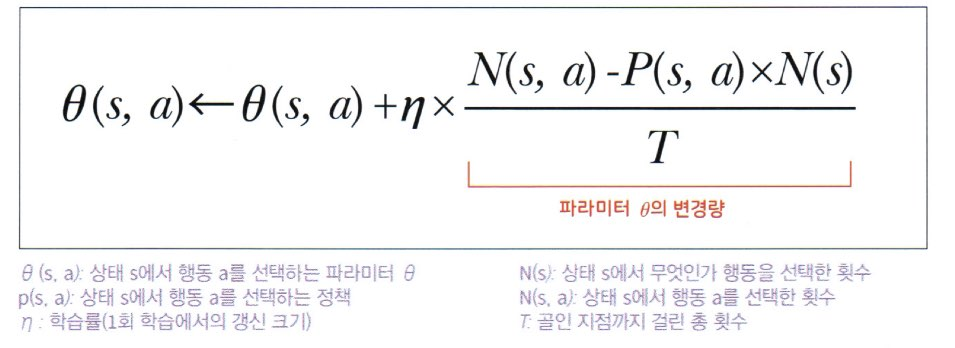

In [48]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/파라미터세타변경량.jpeg')
# s : 상태, 특정 상태
# a : 행동, 특정 상태에서 취할 행동
# θ(s, a) : 특정 상태에서 특정 행동을 취할 확률 => 특정 상태에서의 정책 
# 새로운정책θ(s, a) = 기존정책θ(s, a) + 학습률 * 파라미터 θ의 변경량
# 학습률(η) : 에타(eta), 설정값 변경량을 몇% 적용할 것인가? -> 튜닝의 대상
# T : 에이전트가 0에서 출발하여 8에 도착할대까지 몇번의 시도가 있었는가?(총행동수)
# N(s) : 특정 상태에서 어떤 행동을 취한 총횟수
# N(s,a) : 특정 상태에서 특정 행동을 취한 총회수
# p(s,a) : 특정 상태에서 특정 행동을 취할 확률-> 정책

# (N(s,a) - p(s,a) * N(s)) / T => 특정 확률쪽으로 기울어지면 가중을 시키고(양수값), 
# 반대 쪽으로 가면 감소를 시켜서 (음수값) 정책을 특정 방향을 계속 기울인다

## 정책 갱신 함수(정책계산)

In [ ]:
from itertools import tee
def update_thetaPolicy( theta_zero, policy, act_his ):
  '''
    - theta_zero : 최초 세타 (nan이 존재하는)
    - policy     : 정책, 확률
    - act_his    : 에피소드의 행동 로그
  '''
  # 학습률 -> 고정, 설정
  eta = 0.1 # 세타변경량의 10%만 정책에 반영
  # 총 행동 횟수 = 총로그수 - 1회( [8, nan] )
  T   = len(act_his) - 1
  # 파라미터 세타 변경량을 저장한 그릇
  paramTheta = theta_zero.copy()

  # 상태의 총개수
  state_count, action_count = theta_zero.shape # ( 8, 4 )
  for s in range( state_count ):    # 0 ~ 8
    for a in range( action_count ): # 0 ~ 3
      # 대상이 아닌것!! 제외
      if not theta_zero[ s, a ]: continue
      # 갱신의 대상인 케이스

      # 특정 상태 s에서 특정 행동 a를 취한 총개수
      n_sa = len( [ 0 for log in act_his if log == [s, a] ] )
      # 특정 상태 s에서 특정 행동 a를 취할 확률
      p_sa = policy[ s, a ]
      # 특정 상태 s에서 행동을 취한 총개수
      n_s  = sum( [ 1 for log in act_his if log[0] == s ] )
      # 파라미터 세타의 변경량
      # 각 (s,a) 자리에 계산된 값이 세팅된다
      paramTheta[s, a] = ( n_sa - p_sa * n_s ) / T

  
  #return 원래정책 + 에타*세타변경량
  return theta_zero + eta*paramTheta

newTheta = update_thetaPolicy( theta_zero, theta, act_his )
newTheta

array([[       nan, 1.00178571, 0.99821429,        nan],
       [       nan, 0.99761905, 1.00119048, 1.00119048],
       [       nan,        nan,        nan, 1.        ],
       [0.99821429,        nan, 1.00178571,        nan],
       [1.        , 1.        ,        nan,        nan],
       [       nan,        nan, 1.00178571, 0.99821429],
       [1.        , 1.        ,        nan,        nan],
       [       nan,        nan,        nan, 1.        ]])

# 에피소드 1000번 적용

In [ ]:
SIMULATION_COUNTS   = 1000
EPISODES_STOP_VALUE = 10**-3
EPISODES_STOP_VALUE

0.001

In [ ]:
for epi in range( SIMULATION_COUNTS ) :
  # 1. 에피소드 진행 -> 0 ~ 8까지 도착하기 위해서 행동 -> 로그리턴
  act_his  = simulation_game( theta )
  # 2. 로그 -> 정책 갱신
  newTheta = update_thetaPolicy( theta_zero, theta, act_his )
  # 3. 정책 변동량 점검
  # 3-1. 새로운 정책을 확률값으로 변환
  newTheta = mySoftmax( newTheta )
  # 3-2. 새로운 정책과 기존 정책간의 오차값(거리값)의 총합
  policy_delta = np.sum(np.abs(newTheta-theta))
  # 4. 정책 교체
  theta = newTheta
  # 5. 로그 (verbose)
  print( f'에피소드 {epi:4} 정책변동량 {policy_delta}' )
  # 6. 변동량을 체크하여 미비해지면, EPISODES_STOP_VALUE 이하면 종료
  if policy_delta < EPISODES_STOP_VALUE:
    break

에피소드    0 정책변동량 0.02103534926778161
에피소드    1 정책변동량 0.03910141802946171
에피소드    2 정책변동량 0.03550533241127579
에피소드    3 정책변동량 0.013040485946962943
에피소드    4 정책변동량 0.032947512646804844
에피소드    5 정책변동량 0.03126219876298847
에피소드    6 정책변동량 0.01586689255604906
에피소드    7 정책변동량 0.011003807456553216
에피소드    8 정책변동량 0.015236717175304115
에피소드    9 정책변동량 0.017596566112038137
에피소드   10 정책변동량 0.014033331173230468
에피소드   11 정책변동량 0.05101387159686793
에피소드   12 정책변동량 0.0472857101475761
에피소드   13 정책변동량 0.03379989872585992
에피소드   14 정책변동량 0.030294174168737698
에피소드   15 정책변동량 0.0128864195720641
에피소드   16 정책변동량 0.012766871778058742
에피소드   17 정책변동량 0.014906978395668957
에피소드   18 정책변동량 0.03376343582562319
에피소드   19 정책변동량 0.03136819866607449
에피소드   20 정책변동량 0.05241804040998482
에피소드   21 정책변동량 0.036970624203154445
에피소드   22 정책변동량 0.014145477050682198
에피소드   23 정책변동량 0.018204768544615224
에피소드   24 정책변동량 0.01417874785519535
에피소드   25 정책변동량 0.030787185274656514
에피소드   26 정책변동량 0.06264604712667338
에피소드   27 정책변동량 0

In [ ]:
# 최단거리로 이동했다
act_his

[[0, 1], [1, 1], [2, 3], [1, 2], [4, 1], [5, 2], [8, nan]]

In [ ]:
ani = animation.FuncAnimation( fig, agent_drawing, frames=len(act_his), interval=200, repeat=False)
HTML( ani.to_jshtml() )

# 가치 계산법

- 가치를 중시하는 정책 갱신 방법
  - 행동 1회 단위로 파라미터 갱신
    - 행동 수행 => 상태 변경 => 가치가 변경된다 => 이에 따른 정책갱신 수행

- 알고리즘
  - Sarsa
    - 수렴이 느리다. 국소적인 결론에 갇히지 않는다
  - Q Learning
    - 수렴이 빠르다. 국소적인 결론에 갇히지 있다
  - 위의 알고리즘들은 Q 함수를 갱신하면서 진행
    - Q 함수 => 행렬, 배열,...

# 요소 설계

|강화 학습 요소|미로 게임|
|--:|:--|
|에이전트|마우스|
|환경|미로 게임(유한게임)|
|목적|0번 위치에서(입구) 8번 위치까지(골인/출구) 최단거리 이동|
|행동|4방향 존재, 상우하좌(0123)|
|에피소드|0번에서 출발해서 8번에 도착하면 게임 종료|
|상태|에이전트의 위치(0~8)|
|보상|골인하면 즉시보상 + 1|
|정책갱신(학습방법)|Sarsa, Q Learning|
|파라미터변경주기(정책갱신시퀀스)|1 행동마다 Q 함수 갱신|
|정책|Q 함수|

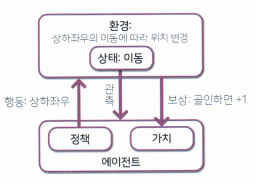

In [49]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화11.png')

# 수익, 할인 보상

- 목표
  - 수익의 극대화
    - 수익 = 즉시보상 + 지연(할인)보상

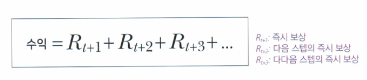

In [50]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화12.png')
# 현재 위치가 0이다 => 그 위치에서 특정행동을 해서 얻을수 있는 수익은?
# 수익 = 즉시보상 + 다음스텝(행동)의 즉시보상 + 다다음스텝의 즉시보상 + .... + 1.0

- 수익 계산 방법 (상세)
  - 미래의 보상에는 할인율이 적용된다
  - 현재 시점에서 미래의 즉시 보상값들을 줄어들수 있다 => 할인이라고 표현
  - 미래 보상에 할인율을 적용하여 합계한것이 현재 시점의 가치(value)로 표현다

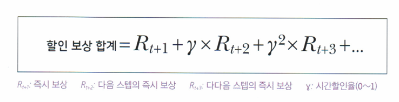

In [51]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화13.png')

# 가치

- 수익
  - 즉시 보상을 제외한 미래에서 얻을 수 있는 수익은 확정되지 않는 값이다. 
  - 에이전트는 조건부로 정책을 고정하여 미래의 수입을 게산할수 있다
  - 이렇게 반영된 수익을 가치라고 부른다
  - **이런 가치를 가장 크게 얻을수 있는 조건을 찾아 내는것 => 학습의 목표이다 **
  - 이를 구현하기 위해 방법
    - **행동 가치 함수**
      - **Q 함수**
      - **Sarsa, Q Learning, DQN,..**
    - 상태 가치 함수
      - V 함수
      - A2C, Dueling Network


- 행동 가치 함수의 value 계산 예시 

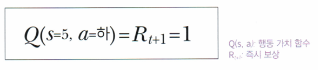

In [52]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화14.png')

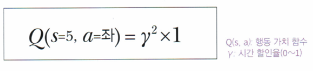

In [53]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화15.png')
# 4번으로 이동하는 바람에 스텝이 2회 추가 되어서
# 가치가 현저하게 줄어들었다
# 0 + γ*0 + γ^2*1 = γ^2*1

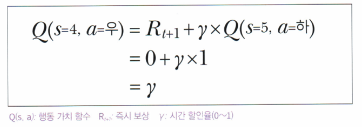

In [54]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화16.png')
# 4 -> 5 -> 8으로 이동할때 가치 계산

- 상태 가치 함수의 value 계산 
예시 
  - 현재 상태에서 가치를 계산
    - 다음 상태로 행동하는 부분은 배제

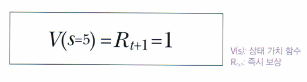

In [55]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화17.png')

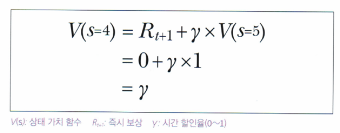

In [56]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화18.png')

#벨만 방정식 (Bellman Equation)

- 행동 가치 함수, 상태 가치 함수를 수학적으료 표현한 것
- 현재 상태와 다음 상태의 관계를 나타내는 방정식

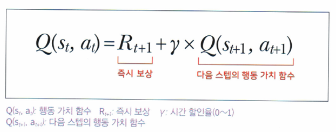

In [57]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화19.png')

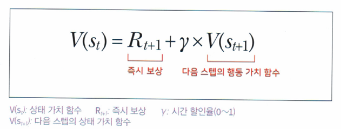

In [58]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화20.png')

# 마르코프 결정과정(Markov Decision Process:MDP)

- 벨만 방정식이 성립하기 위한 환경은 MDP 이여야 한다
- 다음 상태가 현재 상태에서 선택한 행동에 따라 확정되는 시스템
- 벨만 방정식으로 행동 가치함수를 학습하는 방법
  - Saras,Q학습, DQN,..
    - Q 학습을 NN(인공신경망)으로 구현한것 DQN이라고 한다
- 벨만 방정식으로 상태 가치함수를 학습하는 방법
  - A2C, Dueling Network,...

# Q 함수 생성

- 행동가치함수 -> Q함수 구현
- Q함수 = 랜덤값 + theta_zero * 임계값(0.01)

In [ ]:
x, y = theta_zero.shape
Q    = np.random.rand( x, y ) * theta_zero * 0.01
Q

array([[       nan, 0.00749763, 0.00910021,        nan],
       [       nan, 0.00997391, 0.00925875, 0.00159569],
       [       nan,        nan,        nan, 0.00985048],
       [0.00661356,        nan, 0.00210408,        nan],
       [0.00692433, 0.00276096,        nan,        nan],
       [       nan,        nan, 0.00065915, 0.00622507],
       [0.0092539 , 0.00263299,        nan,        nan],
       [       nan,        nan,        nan, 0.00205208]])

In [ ]:
# 특정 상태에서 특정 행동을 취하는 함수 새로 구성
# 앱실론를 개입하여 적용
def getAction( epsilon, policy, state, Q ):
  if epsilon > np.random.rand(): # epsilon값이 만약 0.1이면 10% 확률로 
    # 정책 경사법에서 사용한 선택방법을 활용하여 액션 결정
    # 랜덤 행동(확률기반)
    return np.random.choice([0,1,2,3], p=policy[state])
  else:
    # 상태값이 state일때 Q함수내에서 최대값을 가진 인덱스 선택
    # 행동가치함수(Q함수 활용)
    return np.nanargmax( Q[state] )

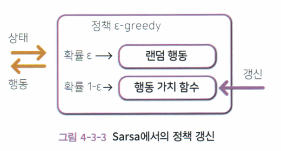

In [59]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화21.png')

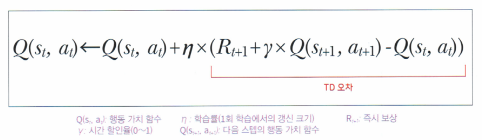

In [60]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/rl/강화22.png')
# 행동 가치 함수 갱신 식 => Q 함수 업데이트 해라 => 정책갱신
# 갱신값 = 현재값 + η(에타:학습률)*TD오차
# TD오차 = 보상을 많이 받는쪽이면(+), 상대적으로 작아지면(-)로 
#          구성되어서 갱신값에 영향을 미친다 

# 행동 가치 함수를 계산하는 알고리즘

- Q 함수 갱신 주기 
  - 1회 행동 -> 계산 -> Q함수 갱신

## sarsa

In [ ]:
def sarsa( Q, s, a, r, s_next, a_next ):      # Q함수가 갱신
  '''
    Q : 행동가치함수, 갱신의 대상, 정책기준
    s : 에이전트의 현재 상태값(위치값)
    s_next : 에이전트의 다음 상태값
    a : 현재 상태 행동
    a_next : 다음 상태 행동
    r : 즉시 보상
  '''
  eta   = 0.1 # 학습률 고정, TD오차의 10%만 행동가치함수 갱신에 관여하겠다
  gamma = 0.9 # 시간 할인율  -> 90% 만 적용(미래가치에) 
  # 에이전트의 위치가 마지막(골인)이다
  if s_next == AGENT_LAST_STATE:
    #Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*0 - Q[ s, a ] )
    Q[ s, a ] = Q[ s, a ] + eta * ( r - Q[ s, a ] )
    pass
  else: #일반적인 모든 위치
    Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*Q[ s_next, a_next ] - Q[ s, a ] )
    pass
  return Q

## Q Learning(Q 학습)

In [ ]:
def q_learning( Q, s, a, r, s_next, a_next ): # Q함수가 갱신
  '''
    Q : 행동가치함수, 갱신의 대상, 정책기준
    s : 에이전트의 현재 상태값(위치값)
    s_next : 에이전트의 다음 상태값
    a : 현재 상태 행동
    a_next : 다음 상태 행동
    r : 즉시 보상
  '''
  eta   = 0.1 # 학습률 고정, TD오차의 10%만 행동가치함수 갱신에 관여하겠다
  gamma = 0.9 # 시간 할인율  -> 90% 만 적용(미래가치에) 
  # 에이전트의 위치가 마지막(골인)이다
  if s_next == AGENT_LAST_STATE:
    Q[ s, a ] = Q[ s, a ] + eta * ( r - Q[ s, a ] )
    pass
  else: #일반적인 모든 위치
    # 어떤 행동을 다음번 스텝에서 취해도 관계없다. 오직 값이 높은 행동만 선택
    # 이것 때문에 수렴도 빠르지만 구소적일수 있다 
    Q[ s, a ] = Q[ s, a ] + eta * ( r + gamma*np.nanmax( Q[ s_next, : ] ) - Q[ s, a ] )
    pass

  return Q

# 행동가치함수 통합 -> 클로저(함수안에 함수)

- 클로저 조건
  - 외부함수가 있고 내부 함수가 있다
  - 내부 함수가 최종 리턴되는 형태를 가진다
  - 함수 자체는 pure 해야한다 -> 어떤 코드에 들어가도 작동이 가능한 형태 -> 전역변수가 함수 내부에 개입되지 않는다

- 클로저 확장 개념 => 데코레이터 => @~

In [ ]:
# 클로저 예시 (단 전역변수 조건은 적용 않됨)
def q_upate_func( Q, s, a, r, s_next, a_next, type='sarsa' ):

  def sarsa( Q, s, a, r, s_next, a_next ): 
    # ...
    return Q

  def q_learning( Q, s, a, r, s_next, a_next ): 
    # ...
    return Q

  if type=='sarsa':
    return sarsa( Q, s, a, r, s_next, a_next )

  return q_learning( Q, s, a, r, s_next, a_next )

# 시뮬레이션

In [ ]:
def game_play( epsilon, Q1, policy ):
  # 초기 상태
  s       = AGENT_FIRST_STATE
  # 이동 로그
  act_his = [ [ s, np.nan ] ]  
  # 초기 다음 스텝 행동
  a_next  = getAction( epsilon, policy, s, Q1 )  
  # 반복 작업 -> 에이전트가 8번 위치에 도착할때까지
  while True:
    # 1. 다음 행동을 현재 행동으로 변경
    a = a_next    
    # 2. 현재 상태에서 취할 행동으로 인한 다음 상태값 획득
    s_next = getNextState( s, a )
    print( s, a, s_next  )
    # 3. 로그 한개 완성 -> 값 수정 : np.nan => 행동값으로 대체
    act_his[-1][-1] = a    
    # 4. 새로운 로그 추가
    act_his.append( [ s_next, np.nan ] )
    # 5. 가치 계산을 위한 보상체크
    if AGENT_LAST_STATE == s_next:
      r = 1           # 다음 상태가 골인 지점이면 즉시보상이 1 제공
      a_next = np.nan #  다음 행동을 없다 (게임종료)
    else:
      r      = 0      # 이외의 상태는 전부 즉시보상이 0
      a_next = getAction( epsilon, policy, s_next, Q1 )
    
    # 6. 행동가치함수 갱신 => Q 갱신 => sarsa, q_learnning
    #    1회 행동 => 해당 포지션에 대한 q함수 갱신
    #Q1 = sarsa( Q1, s, a, r, s_next, a_next )
    Q = q_learning( Q, s, a, r, s_next, a_next )
    
    # 에이전트의 다음 상태값이 최종위치(8)이면 종료
    if AGENT_LAST_STATE == s_next:
      break
    else:
      # 에이전트의 다음 상태값이 현재 상태값으로 치환
      s = s_next

  return act_his, Q1

In [ ]:
policy = mySoftmax(theta_zero)
policy.shape, policy

((8, 4), array([[0.        , 0.5       , 0.5       , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.        , 0.        , 1.        ],
        [0.5       , 0.        , 0.5       , 0.        ],
        [0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.5       , 0.5       ],
        [0.5       , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ]]))

In [ ]:
x, y = theta_zero.shape
Q    = np.random.rand( x, y ) * theta_zero * 0.01
Q

array([[           nan, 1.15643866e-03, 1.90797391e-03,            nan],
       [           nan, 5.69543593e-05, 3.26948281e-03, 9.11107133e-05],
       [           nan,            nan,            nan, 5.96406976e-03],
       [7.68343338e-03,            nan, 2.94234320e-03,            nan],
       [6.17331297e-03, 2.40669309e-03,            nan,            nan],
       [           nan,            nan, 9.88333495e-03, 2.14975883e-03],
       [9.38785672e-03, 6.84894185e-03,            nan,            nan],
       [           nan,            nan,            nan, 4.50543695e-03]])